Now, we must to estimate how many electrons coming from the cathode, in a $^{214}\text{Bi}$ decay, are fiducial background.
<br>
Pau produced a MC and this notebook makes all the preparation (reconstruction and selection) to analize.

In [1]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis/libs')

import crudo
import fit_functions as ff
import glob
from   invisible_cities.reco.corrections import read_maps                   # type: ignore
from   invisible_cities.reco.corrections import apply_all_correction        # type: ignore
from   invisible_cities.types.symbols    import NormStrategy                # type: ignore
import matplotlib.pyplot as plt                                             # type: ignore  
import numpy as np                                                          # type: ignore
import os
import pandas as pd                                                         # type: ignore
import plotting_tools as pt

# Styling Plot
pt.ccortesp_plot_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preliminary

In [2]:
# 1. ANALYSIS PARAMETERS
# ----------------------
V_DRIFT = 0.865     # Drift velocity in [mm/μs]

# --- S1 Signal Cuts ---
# Po-like events are filtered using: S1h >= m * S1e + b
M_NOPOLIKE = 0.17
B_NOPOLIKE = -56

# --- S1e Correction ---
DT_STOP = 1372.2543          # Cathode temporal position in [μs]
CV_FIT  = [0.57, 796.53]     # Fit values for S1e correction vs DT

# --- Alpha/Electron Separation Cut ---
# Events with total corrected energy above this threshold are classified as alphas.
ENERGY_THRESHOLD = 3.0       # in [MeV]

# --- Trigger 2 Efficiency Cut ---
# Events with event-level energy below this are removed to account for trigger efficiency.
TRG2_THRESHOLD = 0.5         # in [MeV]

# 2. DETECTOR REGIONS
# -------------------
# Geometric boundaries for event classification.
Z_LOW = 40          # in [mm]
Z_UP  = 1147        # in [mm]
R_UP  = 451.65      # in [mm]

# 3. DATA DIRECTORIES AND FILENAMES
# ---------------------------------
MC_DIR     = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_09_00/Bi214/CATHODE_SURF/sophronia/'
OUTPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/'

# HDF5 keys
nexus     = '/MC/configuration'
dorothea  = '/DST/Events'
sophronia = '/RECO/Events'
mc_key    = '/MC/Events'

# Columns to be used for the analysis
doro_columns = ['event', 'time', 'nS1', 'nS2', 'S1h', 'S1e', 'S2e', 'DT', 'X', 'Y', 'Z']
soph_columns = ['event', 'time', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ec']

# --- Output Filename ---
OUTPUT_H5 = 'MC_event_background_23092025.h5'

In [3]:
# Aggregation functions
def weighted_avg(series, weight):
    if weight.sum() == 0:                           # Avoid division by zero
        return np.nan
    return np.average(series, weights=weight)

def R_max_func(group_df):
    return np.sqrt(group_df['X']**2 + group_df['Y']**2).max()

# Testing Zone

We first explore the content of the _dorothea_ and _sophronia_ dataframes.

## Reconstruction

In [ ]:
# List all .h5 files in the MC Sophronia directory in alphabetical order
files = sorted(glob.glob(os.path.join(MC_DIR, '*.h5')))

# Initialize empty lists to store the dataframes
run_dst  = []
run_reco = []
doro_counter, soph_counter = 0, 0

# ----- File Loop ----- #
for h5_path in files[:200]:

    # print(f"--- Processing {h5_path} ---")

    try:
        # ----- Dorothea ----- #
        dst_df = pd.read_hdf(h5_path, key=dorothea)
        # dst_df = dst_df.loc[:, doro_columns]          # Activate this when you are completely sure!
        doro_counter += dst_df['event'].nunique()
        run_dst.append(dst_df)

        # ----- Sophronia ----- #
        reco_df = pd.read_hdf(h5_path, key=sophronia)
        # reco_df = reco_df.loc[:, soph_columns]
        soph_counter += reco_df['event'].nunique()
        run_reco.append(reco_df)

    except KeyError as e:
        print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

# ----- Concatenate Data ----- #
test_doro = pd.DataFrame()
test_soph = pd.DataFrame()

if run_dst:
    test_doro = pd.concat(run_dst, ignore_index=True)

if run_reco:
    test_soph = pd.concat(run_reco, ignore_index=True)

# ----- Print Summary ----- #
print(f"--- You have loaded {len(run_dst)} files ---")
print(f"Dorothea events  = {doro_counter}")
print(f"Sophronia events = {soph_counter}")

--- You have loaded 200 files ---
Dorothea events  = 11192
Sophronia events = 10922


#### Why are those numbers different?

If the $S2$ signal is not strong enough to activate the SiPMs (lower charge than the threshold), a false hit is created with negative values in $XYZ$ but the energy of the corresponding slice is stored.
<br>
__Hyp:__ Sophronia ignores pairs with _weak_ $S2$ signals.

In [6]:
print(test_doro[test_doro.event == 313].s2_peak.nunique())
test_doro[test_doro.event == 31]

3


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
53,31,6.309883e+07,65535,0,0,1,NaN,NaN,NaN,NaN,...,48577,NaN,NaN,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0


In [7]:
print(test_soph[test_soph.event == 313].npeak.nunique())
test_soph[test_soph.event == 31]

3


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
31892,31,6.309883e+07,1,-999999.0,-999999.0,1,-65.775,106.975,0.0,0.0,10.844876,11.594203,4731.410301,-1.0,0.011446,-1,-1.0
31893,31,6.309883e+07,1,-999999.0,-999999.0,1,-65.775,399.425,0.0,0.0,10.844876,6.492754,2649.589699,-1.0,0.006920,-1,-1.0


In [6]:
# ----- Dorothea ----- #
weak_S2_ids = test_doro.loc[test_doro['S2q'] < 0, 'event'].unique()     # List of events with weaks S2

# ----- Sophronia ----- #
weak_S2_in_soph_ids = []

for evt_id in weak_S2_ids:

    # Dorothea
    df_doro = test_doro[test_doro['event'] == evt_id]
    nS2_doro = df_doro['s2_peak'].nunique()

    # Sophronia
    df_soph = test_soph[test_soph['event'] == evt_id]
    nS2_soph = df_soph['npeak'].nunique()

    if nS2_doro == nS2_soph:
        weak_S2_in_soph_ids.append(evt_id)
    else:
        continue

print(f"From {len(weak_S2_ids)} events with weak S2 in Dorothea, {len(weak_S2_in_soph_ids)} have the same number of S2 peaks in Sophronia.")

From 4616 events with weak S2 in Dorothea, 311 have the same number of S2 peaks in Sophronia.


Most of the pairs with $S2$ weak are ignored in Sophronia.

In [9]:
hits_S2_weak = []
hits_S2_norm = []

for evt_id in weak_S2_in_soph_ids:

    print(f"--- Event {evt_id}: ---")

    # Sophronia
    df_soph_npeak = test_soph[test_soph['event'] == evt_id].groupby('npeak')

    for npeak_id, group in df_soph_npeak:

        if (group['Xpeak'] < -5000).any():  # These are the weak S2 peaks
            hits_S2_weak.append(len(group))
            print(f"  Peak {npeak_id} is weak and has {len(group)} hits.")
        else:
            hits_S2_norm.append(len(group))

--- Event 31: ---
  Peak 1 is weak and has 2 hits.
--- Event 49: ---
  Peak 2 is weak and has 1 hits.
--- Event 78: ---
  Peak 0 is weak and has 1 hits.
--- Event 94: ---
  Peak 0 is weak and has 2 hits.
--- Event 231: ---
  Peak 0 is weak and has 1 hits.
--- Event 238: ---
  Peak 0 is weak and has 1 hits.
--- Event 250: ---
  Peak 1 is weak and has 6 hits.
--- Event 257: ---
  Peak 2 is weak and has 1 hits.
--- Event 313: ---
  Peak 0 is weak and has 1 hits.
--- Event 336: ---
  Peak 0 is weak and has 5 hits.
--- Event 362: ---
  Peak 1 is weak and has 2 hits.
--- Event 385: ---
  Peak 2 is weak and has 6 hits.
--- Event 400: ---
  Peak 1 is weak and has 1 hits.
--- Event 636: ---
  Peak 0 is weak and has 1 hits.
--- Event 749: ---
  Peak 3 is weak and has 5 hits.
--- Event 772: ---
  Peak 0 is weak and has 2 hits.
--- Event 814: ---
  Peak 0 is weak and has 1 hits.
--- Event 815: ---
  Peak 1 is weak and has 2 hits.
--- Event 817: ---
  Peak 1 is weak and has 1 hits.
--- Event 818: -

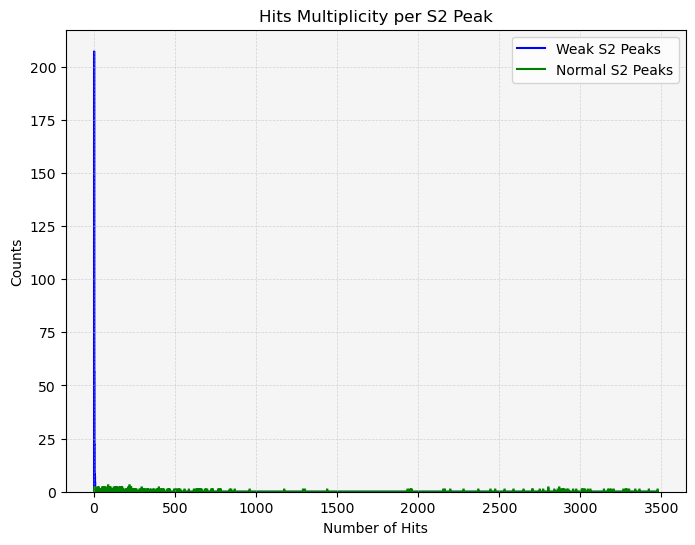

In [19]:
# Global
min_hits = min(min(hits_S2_weak), min(hits_S2_norm))
max_hits = max(max(hits_S2_weak), max(hits_S2_norm))
bins = np.arange(min_hits, max_hits + 2)

# Histogram for hits_S2_weak
hits_weak_counts, hits_weak_edges = np.histogram(hits_S2_weak, bins=bins)

# Histogram for hits_S2_norm
hits_norm_counts, hits_norm_edges = np.histogram(hits_S2_norm, bins=bins)

# Plotting
plt.figure(figsize=(8, 6))
plt.stairs(hits_weak_counts, hits_weak_edges, fill=False, lw=1.5, ec='blue', label='Weak S2 Peaks')
plt.stairs(hits_norm_counts, hits_norm_edges, fill=False, lw=1.5, ec='green', label='Normal S2 Peaks')

# Styling
plt.xlabel('Number of Hits')
# plt.xlim(0, 100)
plt.ylabel('Counts')
plt.title('Hits Multiplicity per S2 Peak')
plt.legend()

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

I will ignore all these weak $S2$ peaks.

## Cleaning Part

In [16]:
# Remove weak S2 peaks in Dorothea and Sophronia
test_doro = test_doro[test_doro['S2q'] >= 0].copy()
test_soph = test_soph[test_soph['Xpeak'] >= -5000].copy()

print(f"After removing weak S2 peaks: {test_soph['event'].nunique()} events ({test_soph['event'].nunique()/soph_counter:.2%})")

# Set hits with NaN or negative energy to 0
test_soph['Ec'] = np.where(
                                pd.notna(test_soph['Ec']) & (test_soph['Ec'] > 0),        # Condition
                                test_soph['Ec'],                                          # Value if condition is True
                                0                                                         # Value if condition is False   
)

# Update dataframes
good_evts_01 = test_soph['event'].unique()
test_doro = test_doro[test_doro['event'].isin(good_evts_01)].copy()     # Keep only events with good sophronia info

print(f"After set hits with NaN or negative energy to 0: {len(good_evts_01)} events ({len(good_evts_01)/soph_counter:.2%})")

After removing weak S2 peaks: 10767 events (98.58%)
After set hits with NaN or negative energy to 0: 10767 events (98.58%)


## $S1$ Signal

#### How does the $S1$ behave?

In [27]:
test_doro['nS1'].value_counts()

1    13071
0     1420
2       70
Name: nS1, dtype: int64

I would not expect events with $0\,S1$ (anode-like), let's see some of them

In [24]:
evts_NO_S1 = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique()
print(len(evts_NO_S1))

1303


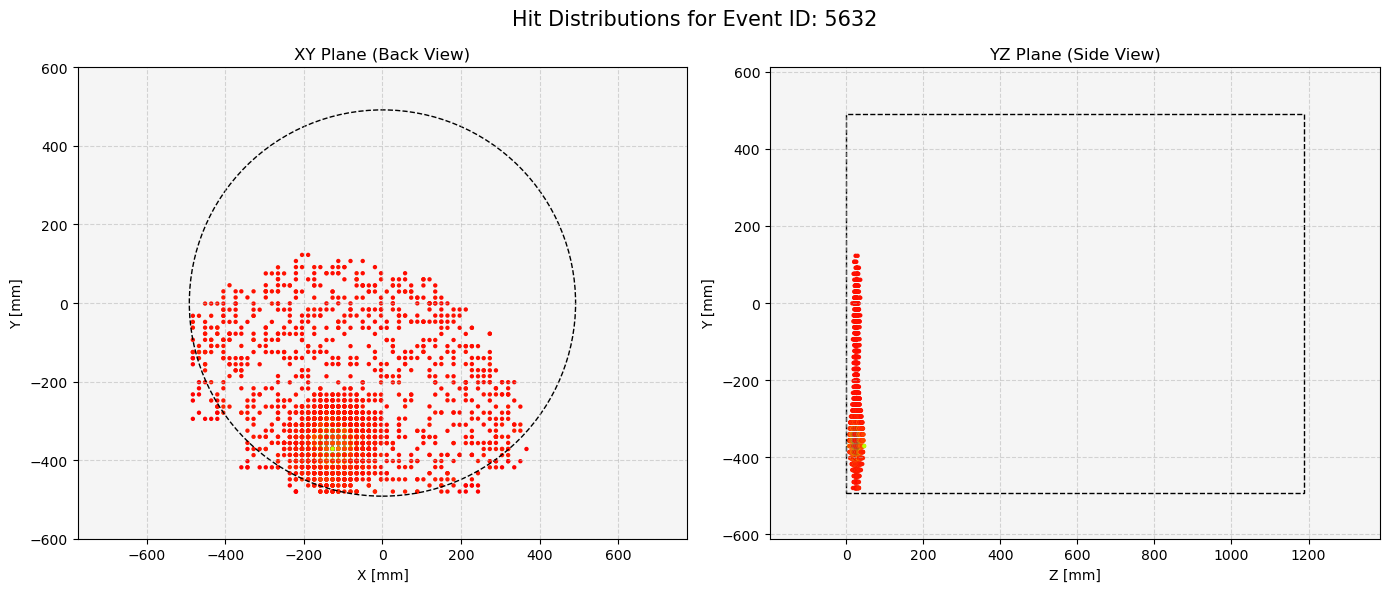

In [77]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(evts_NO_S1))

But yeah, they look like events near to the anode, in particular, coming from the edges of the detector.

In [ ]:
# ----- nS1 = 1 ----- #
data_S1 = test_doro[test_doro['nS1'] == 1].copy()

# ----- nS1 = 1 & nS2 = 1 ----- #
data_S1_S2 = data_S1[data_S1['nS2'] == 1].copy()

# ----- S1e Correction ----- #
data_S1    = crudo.correct_S1e(data_S1,    CV_FIT, DT_STOP, output_column='S1e_corr')
data_S1_S2 = crudo.correct_S1e(data_S1_S2, CV_FIT, DT_STOP, output_column='S1e_corr')

Is the $S1$ energy corrected?

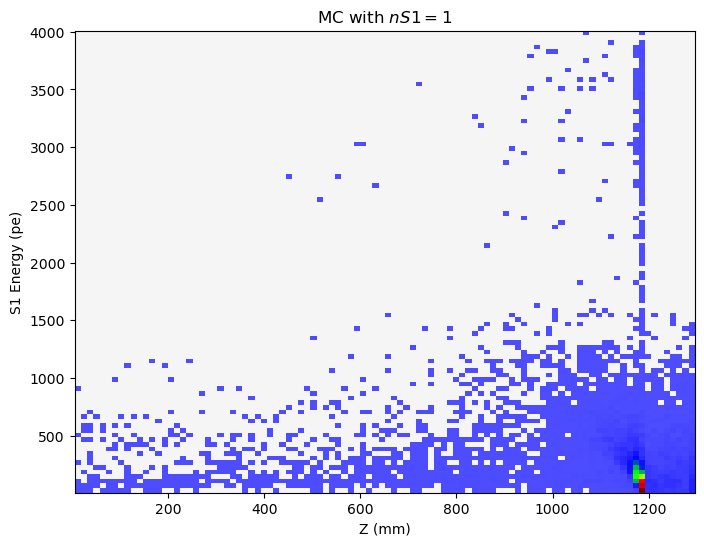

In [109]:
# Global
n_bins = 100
E1_max = 3e3; Z_max = pt.N100_hei

# Variables
E1 = data_S1['S1e']
Z  = data_S1['Z']

# Binning
E1_bins = np.linspace(E1.min(), E1.max(), n_bins)
Z_bins = np.linspace(0, Z_max, n_bins)

# 2D histogram
S1e_Z_map, ex, ey = np.histogram2d(Z, E1, bins=n_bins)
S1e_Z_map         = np.ma.masked_where(S1e_Z_map==0, S1e_Z_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1e_Z_map.T, cmap=pt.custom_hsv, shading='auto')

# ----- Styling ----- #
# cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Z (mm)')
plt.ylabel('S1 Energy (pe)')
plt.title(r'MC with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

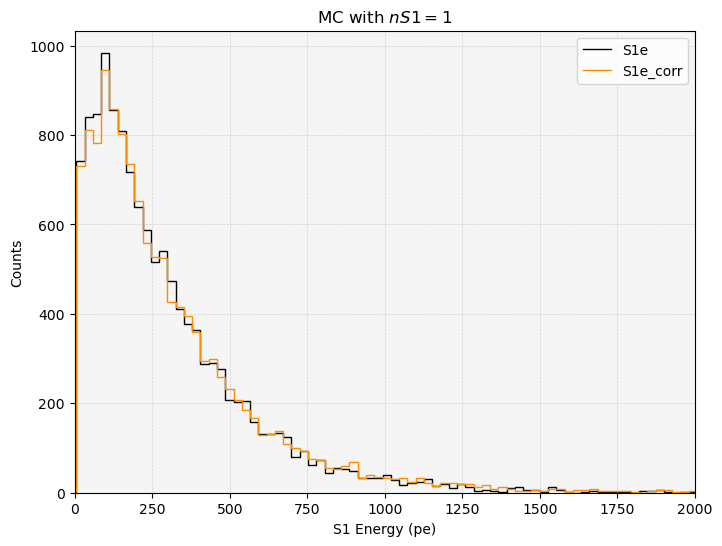

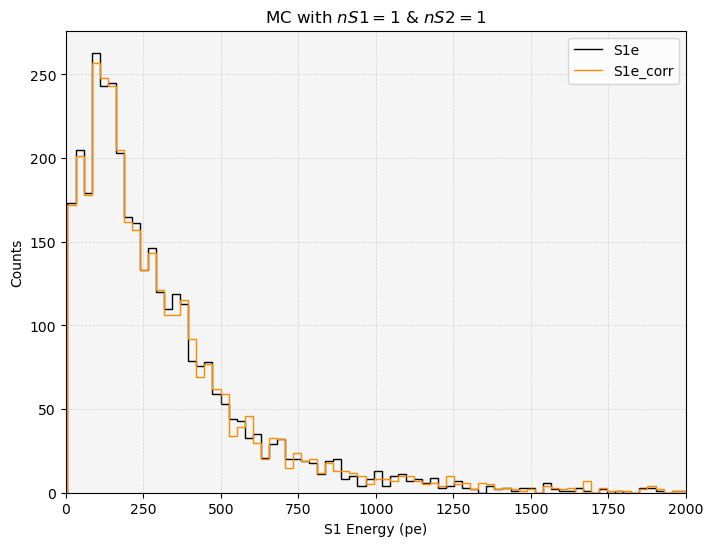

In [ ]:
# Global
n_bins = 150
E1_max = 2e3
titles = [r'MC with $nS1 = 1$', r'MC with $nS1 = 1$ & $nS2 = 1$']

for i, df in enumerate([data_S1, data_S1_S2]):

    plt.figure(figsize=(8, 6))
    plt.title(titles[i])
    _, E1_edges = np.histogram(df['S1e'], bins=n_bins)

    for j, col in enumerate(['S1e', 'S1e_corr']):

        # Variables
        E1 = df[col]

        # Histogram
        E1_counts, _ = np.histogram(E1, bins=E1_edges)

        # ----- Plotting ----- #
        plt.stairs(E1_counts, E1_edges, label=f'{col}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j*2 % len(pt.hist_colors)])

    # Styling
    plt.xlabel('S1 Energy (pe)')
    plt.xlim(0, E1_max)
    plt.ylabel('Counts')
    plt.legend()

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

The $S1e$ correction is very small, given that they are mostly cathode events.

#### Is it important a NO-Polike cut?

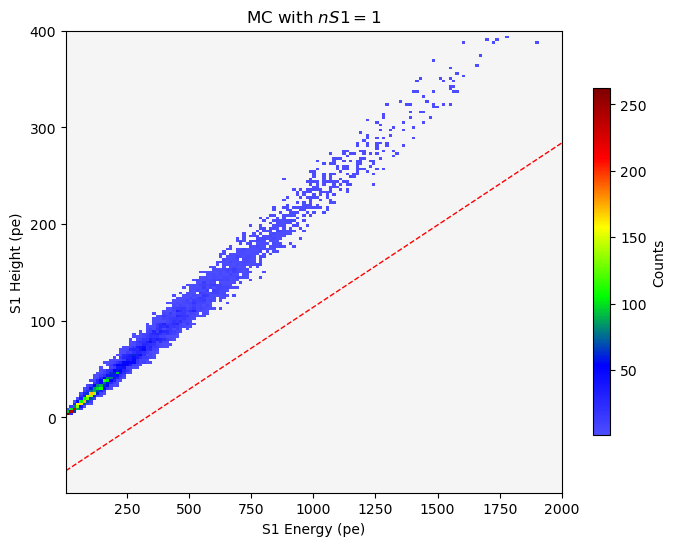

In [ ]:
# Global
n_bins = 150
H1_max = 400; E1_max = 2e3

# Variables
H1 = data_S1['S1h']
E1 = data_S1['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1_max, n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, M_NOPOLIKE, B_NOPOLIKE), c='red', ls='--', lw=1)        # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('S1 Energy (pe)')
plt.ylabel('S1 Height (pe)')
plt.title(r'MC with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

Nope, it is completely unnecesary.

In [ ]:
print("After S1 signal cuts:")

# ----- Counters for Efficiencies ----- #
evt_prior = test_soph['event'].nunique()
nS1_0_evt_ids = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique();   print(f"    nS1 = 0: {len(nS1_0_evt_ids)} events ({len(nS1_0_evt_ids)/evt_prior:.2%})")
nS1_1_evt_ids = test_doro.loc[test_doro['nS1'] == 1, 'event'].unique();   print(f"    nS1 = 1: {len(nS1_1_evt_ids)} events ({len(nS1_1_evt_ids)/evt_prior:.2%})")

# ----- S1 Signal ----- #
test_doro = test_doro[(test_doro['nS1'] == 0) | (test_doro['nS1'] == 1)].copy()

# ----- S1e Correction ----- #
test_doro = crudo.correct_S1e(test_doro, CV_FIT, DT_STOP, output_column='S1e_corr')    # I'll work with this corrected S1 energy
# Check if the correction was applied
if 'S1e_corr' not in test_doro.columns:
    print(f"Error: S1e correction not applied! Skipping...")

# Update dataframes
good_evts_02 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evts_02)].copy()

print(f"{len(good_evts_02)} events ({len(good_evts_02)/evt_prior:.2%})")

After S1 signal cuts:
    nS1 = 0: 1303 events (12.10%)
    nS1 = 1: 9440 events (87.68%)
10743 events (99.78%)


## $S2$ Signal

#### How does it behave the $S2$ energy?

In [131]:
# ----- nS2 = 1 ----- #
data_S2 = test_doro[test_doro['nS2'] == 1].copy()

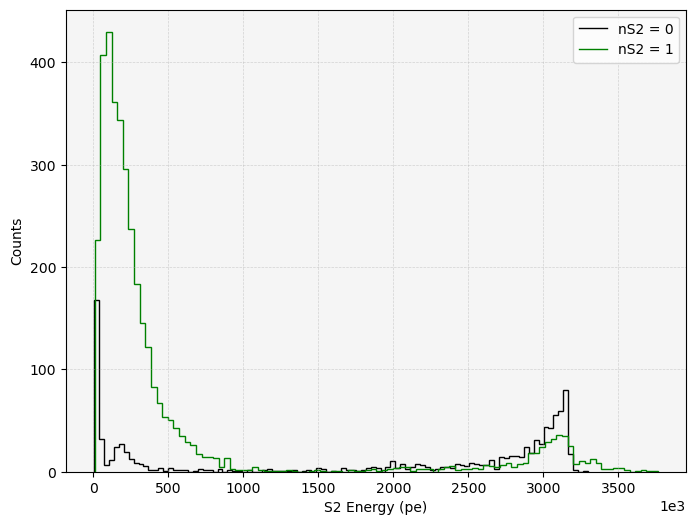

In [150]:
# Global
n_bins = 100
E2_max = 2000e3

plt.figure(figsize=(8, 6))

for i, label in enumerate(['nS2 = 0', 'nS2 = 1']):
    
    if label == 'nS2 = 0':
        data = data_S2[data_S2['nS1'] == 0].copy()
        E2 = data['S2e']
    else:
        data = data_S2[data_S2['nS1'] == 1].copy()
        E2 = data['S2e']

    # Histogram
    E2_counts, E2_edges = np.histogram(E2, bins=n_bins)

    # ----- Plotting ----- #
    plt.stairs(E2_counts, E2_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[4*i % len(pt.hist_colors)])

# Styling
plt.xlabel('S2 Energy (pe)')
# plt.xlim(0, E2_max)
plt.ylabel('Counts')
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend()

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

We know that alpha population is around $1000\times10^{3}\,\text{pe}$.
<br>
The $nS2 = 1$ cut remove almost all the aplha contribution (BiPo coincidence!).
<br>
In any case, let's check that population of events around $3000\times10^{3}\,\text{pe}$.

In [ ]:
pop_3000_ids = data_S2.loc[data_S2['S2e'] >= 3000e3, 'event'].unique()
print(len(pop_3000_ids))

536


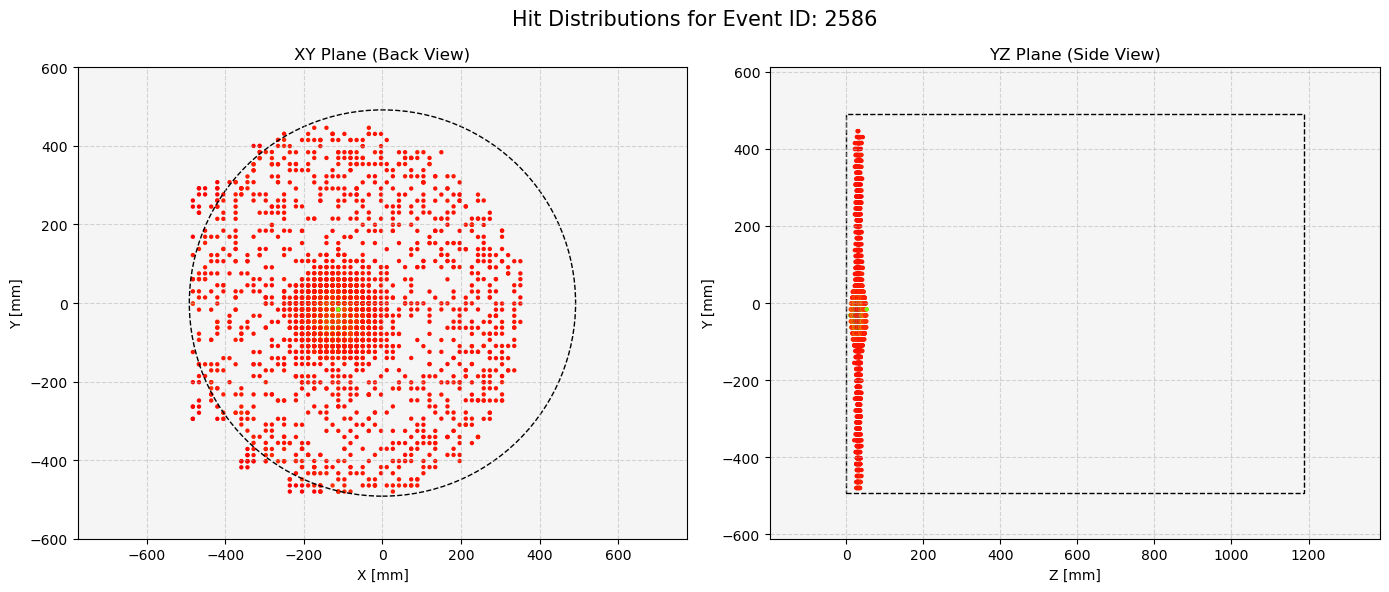

In [232]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_3000_ids))

This population seems to be alphas but with so many hits! __Why?__

In [203]:
pop_std_ids = data_S2.loc[data_S2['S2e'] < 1500e3, 'event'].unique()
print(len(pop_std_ids))

3614


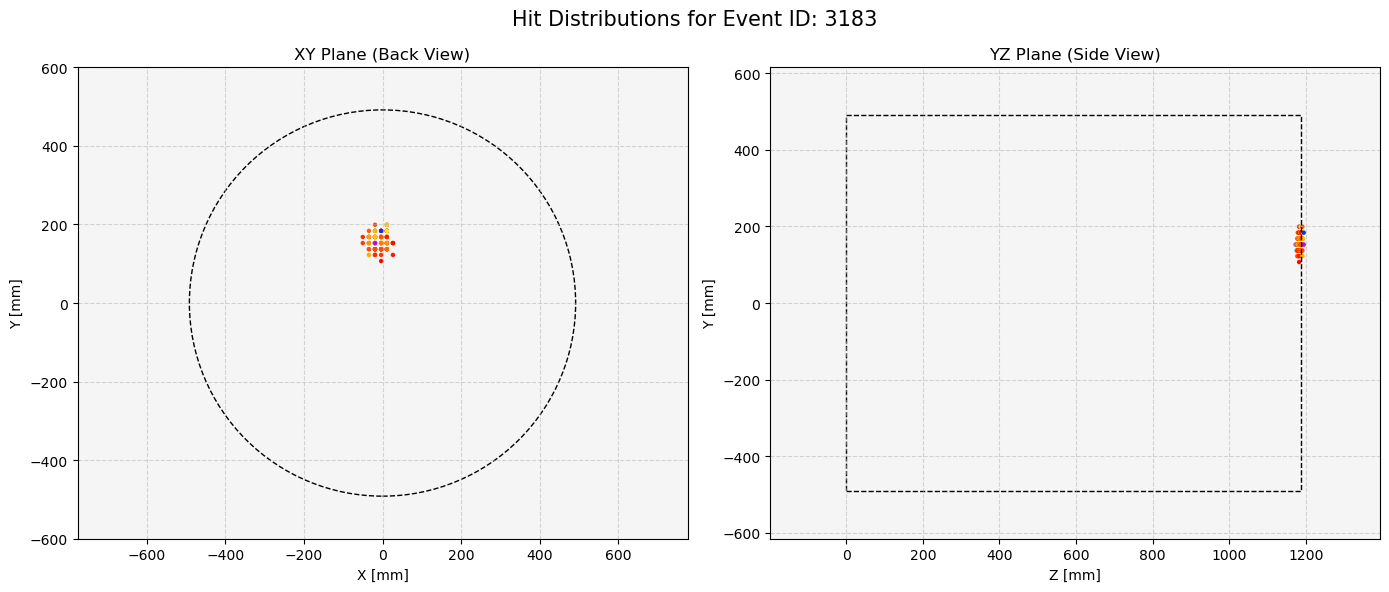

In [224]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_std_ids))

Here I notice more events "well-reconstructed", but we still need to distinguish between alphas and electrons.
<br>
First, we apply the $nS2 = 1$ cut.
<br>
__Notice the low efficieny, we are killing the BiPo coincidence!__

In [233]:
# Event counter
evt_prior = test_soph['event'].nunique()

# ----- S2 Signal ----- #
test_doro = test_doro[test_doro['nS2'] == 1].copy()

# Update dataframes
good_evt_03 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evt_03)].copy()

print(f"After S2 signal cut: {len(good_evt_03)} events ({len(good_evt_03)/evt_prior:.2%})")

After S2 signal cut: 4670 events (43.47%)


## $\alpha$ and $e$ Populations

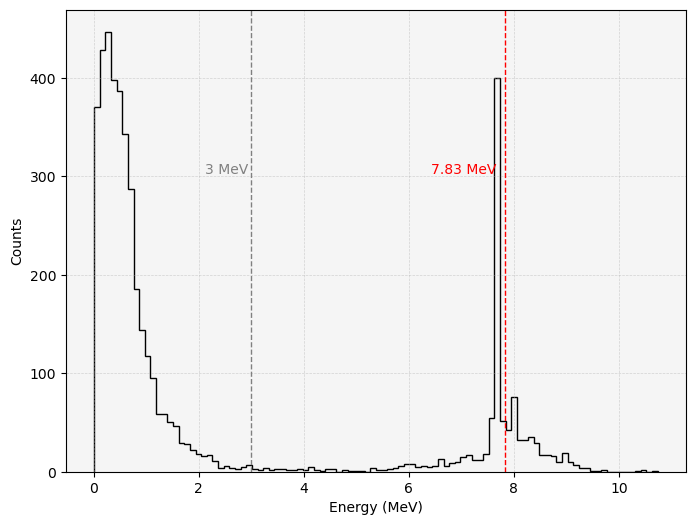

In [243]:
# Global
n_bins = 100

# Variables
E = test_soph.groupby('event')['Ec'].sum()

# Histogram
E_counts, E_edges = np.histogram(E, bins=n_bins)

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.stairs(E_counts, E_edges,
           fill=False, lw=1.0, ec='black')
    
# 214Po peak as reference!
x_Po = 7.83
plt.axvline(x=x_Po, color='red', ls='--', lw=1)
plt.text(0.98*x_Po, 300, f'{x_Po} MeV', c='red', ha='right', va='bottom')

# Energy threshold
x_flag = 3
plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
plt.text(0.98*x_flag, 300, f'{x_flag} MeV', c='gray', ha='right', va='bottom')

# ----- Styling ----- #
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
# plt.yscale('log')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

As alphas, we expect to have them around $7.83\,\text{MeV}$ (the Q value of $^{214}\text{Po}$).
<br>
I will use the same energy threshold to separate alphas and electrons (gray line).

In [ ]:
# Event counter
evt_prior = test_soph['event'].nunique()

# Variables
evt_energy = test_soph.groupby('event')['Ec'].sum()

# Event IDs for alphas and electrons
elec_ids  = evt_energy[evt_energy <= ENERGY_THRESHOLD].index
alpha_ids = evt_energy[evt_energy >  ENERGY_THRESHOLD].index

# Update dataframes
test_doro = test_doro[test_doro['event'].isin(elec_ids)].copy()
test_soph = test_soph[test_soph['event'].isin(elec_ids)].copy() 
print(f"Electron candidates: {len(elec_ids)} events ({len(elec_ids)/evt_prior:.2%}) ")

Electron candidates: 3589 events (76.85%) 


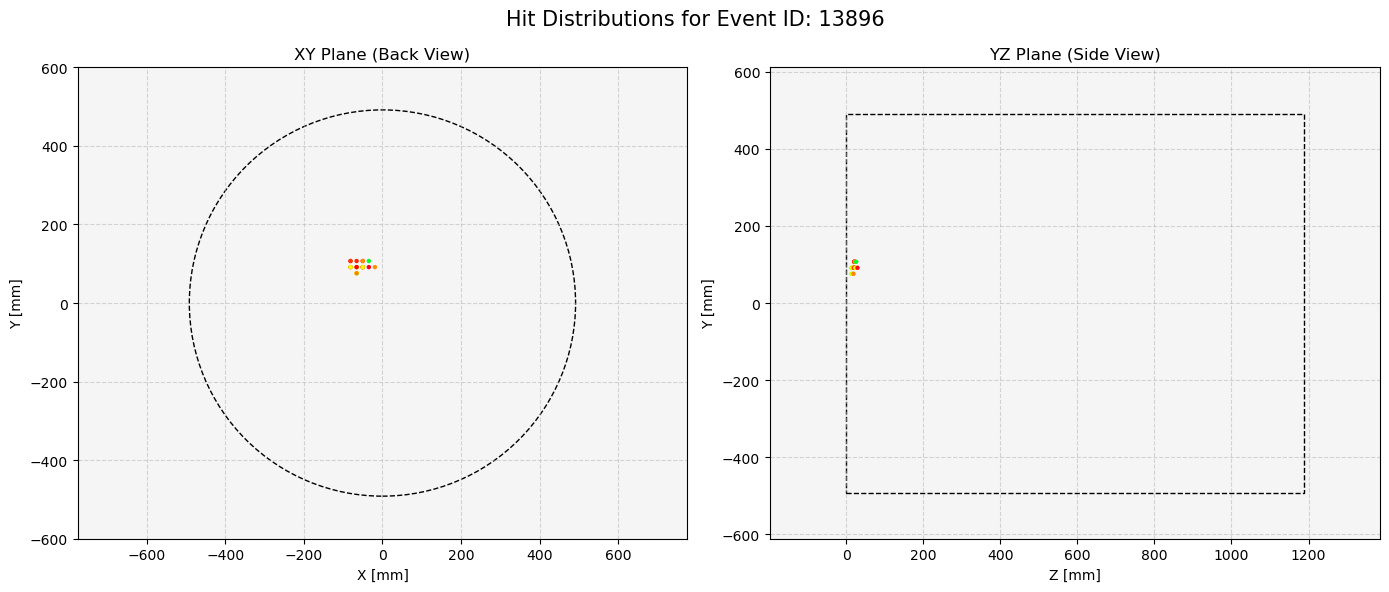

In [291]:
pt.event_display(test_soph, variable='Ec')

# Processing

In [4]:
# Store all the processed dfs
all_processed_dfs = []

# List all .h5 files in the MC Sophronia directory in alphabetical order
files = sorted(glob.glob(os.path.join(MC_DIR, '*.h5')))

# Event counters
Total_gen   = 0
Total_reco  = 0   
Total_clean = 0
Total_nS1 = 0;       Total_nS1_one  = 0;     Total_nS1_zero  = 0
Total_nS2 = 0
Total_electron = 0
Total_final = 0

# ----- File Loop ----- #
for i, h5_path in enumerate(files):

    print(f"--- Processing {i + 1} / {len(files)} ---")

    # ----- Nexus ----- #
    df_nexus = pd.DataFrame()
    try:
        df_nexus = pd.read_hdf(h5_path, key=nexus)
        # Count the number of generated events
        Total_gen += int(df_nexus.loc[df_nexus['param_key'] == 'num_events', 'param_value'].values[0])
    except KeyError:
        print(f"Key {nexus} not found in {h5_path}. Skipping...")
        continue

    # ----- Dorothea ----- #
    df_dorothea = pd.DataFrame()
    try:
        df_dorothea = pd.read_hdf(h5_path, key=dorothea)
    except KeyError:
        print(f"Key {dorothea} not found in {h5_path}. Skipping...")
        continue

    # ----- Sophronia ----- #
    df_sophronia = pd.DataFrame()
    try:
        df_sophronia = pd.read_hdf(h5_path, key=sophronia)
        # Count the number of events after the IC reconstruction chain
        Total_reco += df_sophronia['event'].nunique()
    except KeyError:
        print(f"Key {sophronia} not found in {h5_path}. Skipping...")
        continue

    # ----- Cleaning Part ----- #
    # Remove weak S2 peaks in Dorothea and Sophronia
    df_dorothea = df_dorothea[df_dorothea['S2q'] >= 0].copy()
    df_sophronia = df_sophronia[df_sophronia['Xpeak'] >= -5000].copy()

    # Set hits with NaN or negative energy to 0
    df_sophronia['Ec'] = np.where(
                                    pd.notna(df_sophronia['Ec']) & (df_sophronia['Ec'] > 0),        # Condition
                                    df_sophronia['Ec'],                                             # Value if condition is True
                                    0                                                               # Value if condition is False   
    )

    # Update dataframes
    good_evts_01 = df_sophronia['event'].unique();     Total_clean += df_sophronia['event'].nunique()
    df_dorothea = df_dorothea[df_dorothea['event'].isin(good_evts_01)].copy()

    # ----- S1 Signal ----- #
    Total_nS1_zero += df_dorothea.loc[df_dorothea['nS1'] == 0, 'event'].nunique()
    Total_nS1_one  += df_dorothea.loc[df_dorothea['nS1'] == 1, 'event'].nunique()

    df_dorothea = df_dorothea[(df_dorothea['nS1'] == 0) | (df_dorothea['nS1'] == 1)].copy()
    Total_nS1 += df_dorothea['event'].nunique()

    # S1e Correction (NO mandatory)
    df_dorothea = crudo.correct_S1e(df_dorothea, CV_FIT, DT_STOP, output_column='S1e_corr')

    # ----- S2 Signal ----- #
    df_dorothea = df_dorothea[df_dorothea['nS2'] == 1].copy()
    Total_nS2 += df_dorothea['event'].nunique()

    # Update dataframes
    good_evts_02 = df_dorothea['event'].unique();          
    df_sophronia = df_sophronia[df_sophronia['event'].isin(good_evts_02)].copy()

    # ----- Electron Candidates ----- #
    # Variables
    evt_energy = df_sophronia.groupby('event')['Ec'].sum()
    elec_ids = evt_energy[evt_energy <= ENERGY_THRESHOLD].index

    # Update dataframes
    df_dorothea  = df_dorothea[df_dorothea['event'].isin(elec_ids)].copy()
    df_sophronia = df_sophronia[df_sophronia['event'].isin(elec_ids)].copy()
    Total_electron += df_sophronia['event'].nunique()

    # ----- Final DataFrame @ Event-level ----- #
    # Relevant information from Sophronia: at event and npeak level
    df_file = df_sophronia.groupby(['event', 'npeak'], as_index=False).agg(

                    # Weighted averages for X, Y, Z
                    X=('X', lambda x: weighted_avg(x, df_sophronia.loc[x.index, 'Ec'])),
                    Y=('Y', lambda y: weighted_avg(y, df_sophronia.loc[y.index, 'Ec'])),
                    Z=('Z', lambda z: weighted_avg(z, df_sophronia.loc[z.index, 'Ec'])),
                    # Sum of Ec
                    E_corr=('Ec', 'sum'),
                    # Min and max of Z
                    Z_min=('Z', 'min'),
                    Z_max=('Z', 'max'),
                    # Max R
                    # For R_max, the lambda needs the group DataFrame to access both X and Y
                    R_max=('X', lambda xy_group: R_max_func(df_sophronia.loc[xy_group.index]))

    )

    # Relevant information from Dorothea: at event level
    dorothea_agg = df_dorothea.groupby('event', as_index=False).agg(

                        nS1=('nS1', 'max'),
                        nS2=('nS2', 'max'),

    )

    # Merge aggregated Dorothea data with Sophronia data
    df_file = pd.merge(df_file, dorothea_agg, on='event', how='left')

    # ----- Monte Carlo Information ----- #
    df_file['Isotope'] = 'Bi214'
    df_file['Volume']  = 'CATHODE_SURF'    

    # Append to the main DataFrame
    all_processed_dfs.append(df_file)
    Total_final += df_file['event'].nunique()
    
# ----- Final Verbosity ----- #
print("\n--- Processing Summary ---")
print(f"Total generated events                = {Total_gen} ({Total_gen/Total_gen:.2%})")
print(f"Total events after the reco chain     = {Total_reco} ({Total_reco/Total_gen:.2%})")
print(f"Total events after cleaning           = {Total_clean} ({Total_clean/Total_reco:.2%})")
print(f"Total events after nS1 cut            = {Total_nS1} ({Total_nS1/Total_clean:.2%})")
print(f"    - of which nS1 = 0 ¬ {Total_nS1_zero} ({Total_nS1_zero/Total_clean:.2%})")
print(f"    - of which nS1 = 1 ¬ {Total_nS1_one} ({Total_nS1_one/Total_clean:.2%})")
print(f"Total events after nS2 cut            = {Total_nS2} ({Total_nS2/Total_nS1:.2%})")
print(f"Total events after electron selection = {Total_electron} ({Total_electron/Total_nS2:.2%})")
print(f"Total final events after processing   = {Total_final}")     

--- Processing 1 / 5000 ---
--- Processing 2 / 5000 ---
--- Processing 3 / 5000 ---
--- Processing 4 / 5000 ---
--- Processing 5 / 5000 ---
--- Processing 6 / 5000 ---
--- Processing 7 / 5000 ---
--- Processing 8 / 5000 ---
--- Processing 9 / 5000 ---
--- Processing 10 / 5000 ---
--- Processing 11 / 5000 ---
--- Processing 12 / 5000 ---
--- Processing 13 / 5000 ---
--- Processing 14 / 5000 ---
--- Processing 15 / 5000 ---
--- Processing 16 / 5000 ---
--- Processing 17 / 5000 ---
--- Processing 18 / 5000 ---
--- Processing 19 / 5000 ---
--- Processing 20 / 5000 ---
--- Processing 21 / 5000 ---
--- Processing 22 / 5000 ---
--- Processing 23 / 5000 ---
--- Processing 24 / 5000 ---
--- Processing 25 / 5000 ---
--- Processing 26 / 5000 ---
--- Processing 27 / 5000 ---
--- Processing 28 / 5000 ---
--- Processing 29 / 5000 ---
--- Processing 30 / 5000 ---
--- Processing 31 / 5000 ---
--- Processing 32 / 5000 ---
--- Processing 33 / 5000 ---
--- Processing 34 / 5000 ---
--- Processing 35 / 500

In [5]:
# Concatenation
if all_processed_dfs:
    MC_df = pd.concat(all_processed_dfs, ignore_index=True)

print('Y ya, eso es todo, eso es todo')

Y ya, eso es todo, eso es todo


Let's store the final dataframe as an HDF5 file

In [7]:
MC_df.to_hdf(os.path.join(OUTPUT_DIR, OUTPUT_H5), key='/MC/Events', mode='w', format='table')
print(f"Simulation saved to {os.path.join(OUTPUT_DIR, OUTPUT_H5)}")

Simulation saved to /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/MC_event_background_23092025.h5


# Selection

## Input

In [4]:
# Load the MC DataFrame
MC_df = pd.read_hdf(os.path.join(OUTPUT_DIR, OUTPUT_H5), key=mc_key)

# Initial information
Initial_evts = MC_df['event'].nunique()

print(f"MC uploaded with {Initial_evts} processed events")

MC uploaded with 93186 processed events


We will categorize the selected dataframe into interest regions of the detector.
<br>
In the simulation we have only background (_Electron_ for consistency).

In [5]:
selected_mc_df   = {
                        'Run_time': 315360,  # Simulated exposure (0.01 year) in [s]
                        'Electron': {'Inclusive': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}
                   }

## $E\,\geq\,0.5\,\text{MeV}$

In [6]:
MC_df = MC_df[MC_df['E_corr'] >= TRG2_THRESHOLD].copy()
selected_mc_df['Electron']['Inclusive'] = MC_df.copy()

print(f"After energy cut ({TRG2_THRESHOLD} MeV): {MC_df['event'].nunique()} events ({MC_df['event'].nunique()/Initial_evts:.2%})")

After energy cut (0.5 MeV): 42288 events (45.38%)


## Detector Regions

In [7]:
# ----- Spatial Classification ----- #
is_anode_NO_S1_mask = MC_df['nS1'] == 0
anode_NO_S1_ids = MC_df.loc[is_anode_NO_S1_mask, 'event'].unique()
print(f"Found {len(anode_NO_S1_ids)} events with nS1 = 0 (Anode candidates)")

# Ignore these events for the spatial selection
MC_S1_df = MC_df[~is_anode_NO_S1_mask].copy()

# Detector regions
is_z_contained = (MC_S1_df['Z_min'] >= Z_LOW) & (MC_S1_df['Z_max'] <= Z_UP)
is_r_contained = MC_S1_df['R_max'] <= R_UP

# Masks
fiducial_mask = is_z_contained & is_r_contained
tube_mask     = is_z_contained & ~is_r_contained
anode_mask    = MC_S1_df['Z_min'] < Z_LOW
cathode_mask  = MC_S1_df['Z_max'] > Z_UP

# Event IDs for each detector region
fiducial_ids = MC_S1_df.loc[fiducial_mask, 'event'].unique()
tube_ids     = MC_S1_df.loc[tube_mask, 'event'].unique()
cathode_ids  = MC_S1_df.loc[cathode_mask, 'event'].unique()

# Combine both types of anode events
anode_spatial_ids = MC_S1_df.loc[anode_mask, 'event'].unique()
anode_ids = np.union1d(anode_NO_S1_ids, anode_spatial_ids)

# ----- Validation ----- #
all_ids = np.concatenate([fiducial_ids, tube_ids, anode_ids, cathode_ids])
assert len(all_ids) == len(np.unique(all_ids)), "Error: Overlap found between regions!"
assert len(all_ids) == len(MC_df), "Error: Not all events were classified!"

# ----- Store DataFrames ----- #
selected_mc_df['Electron']['Fiducial'] = MC_df[MC_df['event'].isin(fiducial_ids)].copy()
selected_mc_df['Electron']['Tube']     = MC_df[MC_df['event'].isin(tube_ids)].copy()
selected_mc_df['Electron']['Anode']    = MC_df[MC_df['event'].isin(anode_ids)].copy()
selected_mc_df['Electron']['Cathode']  = MC_df[MC_df['event'].isin(cathode_ids)].copy()

# --- Printing Extra Information --- #
evts_prior = MC_df['event'].nunique()
duration = selected_mc_df['Run_time']

print(f"\n--- Classification Results ---")
print(f"Fiducial: {len(fiducial_ids)} events ({len(fiducial_ids)/evts_prior:.2%}) || Rate = {len(fiducial_ids)/duration:.2e} Hz")
print(f"Tube:     {len(tube_ids)} events ({len(tube_ids)/evts_prior:.2%})")
print(f"Anode:    {len(anode_ids)} events ({len(anode_ids)/evts_prior:.2%})")        
print(f"Cathode:  {len(cathode_ids)} events ({len(cathode_ids)/evts_prior:.2%})")

Found 2439 events with nS1 = 0 (Anode candidates)

--- Classification Results ---
Fiducial: 98 events (0.23%) || Rate = 3.11e-04 Hz
Tube:     168 events (0.40%)
Anode:    2460 events (5.82%)
Cathode:  39562 events (93.55%)


# Control Plots

In [8]:
# Duration of the simulated exposure
duration = selected_mc_df['Run_time']

# Detector regions
regions = ['Inclusive', 'Fiducial', 'Tube', 'Anode', 'Cathode']

## Z Distribution

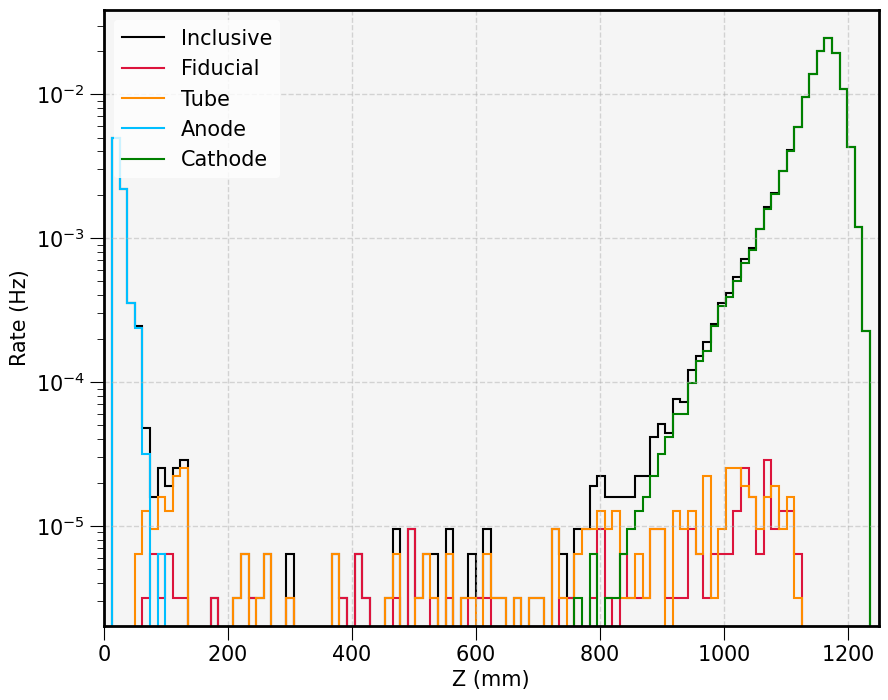

In [27]:
# Global
n_bins = 100

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, Z_edges = np.histogram(mc_all['Z'], bins=n_bins)

for i, region in enumerate(regions):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    Z = mc_region['Z']

    # Histogram
    Z_counts, _ = np.histogram(Z, bins=Z_edges)
    Z_rate = Z_counts / duration

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=region, 
               fill=False, lw=1.5, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# ----- Styling ----- #
plt.xlabel('Z (mm)')
plt.xlim(0, 1250)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend(loc='upper left')

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## E Distribution (_fiducial_)

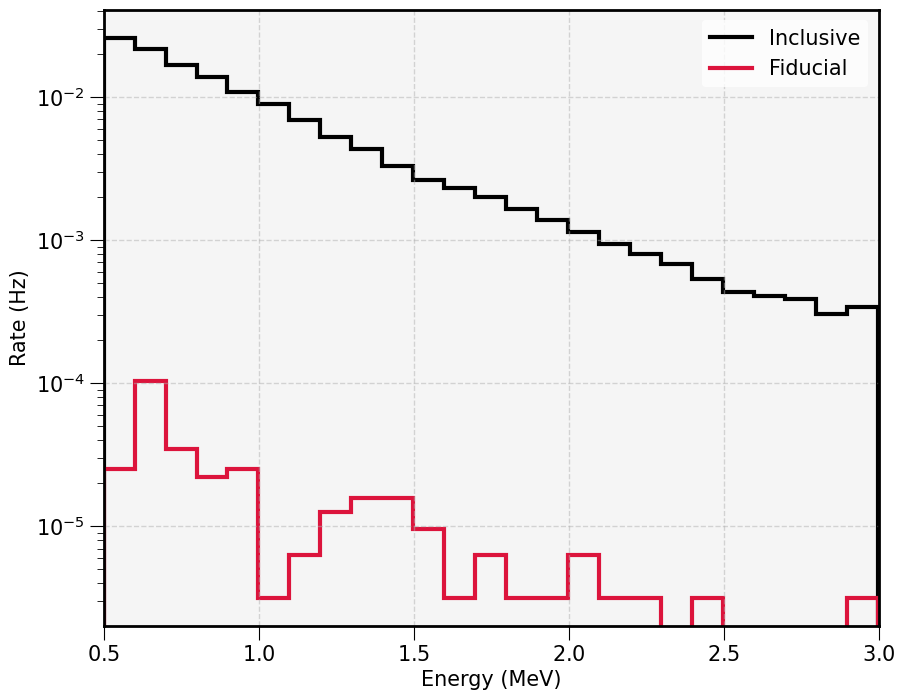

In [9]:
# Global
n_bins = 25

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, E_edges = np.histogram(mc_all['E_corr'], bins=n_bins)

for i, region in enumerate(['Inclusive', 'Fiducial']):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    E = mc_region['E_corr']

    # Histogram
    E_counts, _ = np.histogram(E, bins=n_bins)
    E_rate = E_counts / duration

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=region, 
               fill=False, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# plt.axvline(x=1.59, c='grey', ls='--', lw=1.0)        # DEP
    
# ----- Styling ----- #
plt.xlabel('Energy (MeV)')
plt.xlim(TRG2_THRESHOLD, ENERGY_THRESHOLD)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend()

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Bi_Fiducial.pdf')
plt.show()